In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import torch
import math
from typing import List, Dict, Literal, Tuple, Iterable, Type, Union, Callable, Optional, TYPE_CHECKING
from torch import nn, Tensor, device
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
dev = pd.read_csv("Data\dev.csv",sep="\t")
dev = dev.dropna().reset_index(drop=True)
train = pd.read_csv("Data\train.csv",sep="\t")
train = train.dropna().reset_index(drop=True)

TASK 1B

In [3]:
def scale(x, srcRange, dstRange):
    return (x-srcRange[0])*(dstRange[1]-dstRange[0])/(srcRange[1]-srcRange[0])+dstRange[0]

In [23]:
class TextDataset(Dataset):
    def __init__(self, data,eval=False):
        self.data = data
        self.eval = eval
        if(eval):
            self.sentences1 = self.data.iloc[:,1].tolist()
            self.sentences2 = self.data.iloc[:,2].tolist()
            self.scores = self.data['score'].tolist()
        else:
            self.sentences1 = self.data.iloc[:,1].tolist()
            self.sentences2 = self.data.iloc[:,2].tolist()

    def __len__(self):
        return len(self.sentences1)
    
    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        if(self.eval):
            score = self.scores[idx]       
            return sentence1,sentence2,score
        return sentence1,sentence2


In [14]:
#setting the batch_size as 1 here so that the samples are predicted one by one
dev_dataset = TextDataset(dev,eval=True)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

In [15]:
#using the defined model from the documentation 
model = SentenceTransformer("all-MiniLM-L6-v2")
cosine_sim = []
for batch in dev_loader:
    sentences1, sentences2, _ = batch
    embed1 = model.encode(sentences1)
    embed2 = model.encode(sentences2)

    temp = cosine_similarity(embed1.reshape(1,-1),embed2.reshape(1,-1))
    #scaling up the similarity score
    #has a range from -1 to 1 and there are some negative values which have been set to 0
    scaled_cosine = temp[0][0]*5
    if(scaled_cosine<0):
        scaled_cosine=0
    cosine_sim.append(scaled_cosine)



pearson = np.corrcoef(cosine_sim,dev['score'])

In [16]:
print("The pearson score for task 1B is: ", pearson[0][1])

The pearson score for task 1B is:  0.8643580687369818


TASK 1C (done on Kaggle)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)

# Read the dataset
model_name = "nli-distilroberta-base-v2"
train_batch_size = 64
num_epochs = 3

# Load a pre-trained sentence transformer model
model = SentenceTransformer(model_name)
model.to(device)
# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []


# input sample
#scaling the scores down in the range (0,1) here
for index,rows in train.iterrows():
    score_scaled = rows["score"]/5
    input_train = InputExample(texts = [rows["sentence1"],rows["sentence2"]],label=score_scaled)
    train_samples.append(input_train)

for index,rows in dev.iterrows():
    score_scaled = rows["score"]/5
    input_train = InputExample(texts = [rows["setence1"],rows["sentence2"]],label=score_scaled)
    dev_samples.append(input_train)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=64)

In [11]:
train_loss = losses.CosineSimilarityLoss(model=model)

model_save_path = (
    "/kaggle/working/" +model_name + "-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

# Development set: Measure correlation between cosine score and gold labels
logging.info("Read dev dataset")
evaluator = EmbeddingSimilarityEvaluator(dev["setence1"], dev["sentence2"], dev["score"])


warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

In [12]:
# Define your checkpoint directory
checkpoint_dir = "/kaggle/working/"

#saving the model after every epoch to get the loss for training and validation 
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    evaluation_steps=90,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path=model_save_path,
    checkpoint_path=checkpoint_dir, 
    checkpoint_save_steps=90,
    checkpoint_save_total_limit=num_epochs
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

In [13]:
#to calculate the loss 
def smart_batching_collate(batch: List["InputExample"]) -> Tuple[List[Dict[str, Tensor]], Tensor]:
    """
    Transforms a batch from a SmartBatchingDataset to a batch of tensors for the model
    Here, batch is a list of InputExample instances: [InputExample(...), ...]

    :param batch:
        a batch from a SmartBatchingDataset
    :return:
        a batch of tensors for the model
    """
    texts = [example.texts for example in batch]
    sentence_features = [model.tokenize(sentence) for sentence in zip(*texts)]
    labels = torch.tensor([example.label for example in batch])
    return sentence_features, labels

In [14]:
dev_dataloader = DataLoader(dev_samples,shuffle=True,batch_size=64)
dev_dataloader.collate_fn = smart_batching_collate
train_dataloader.collate_fn = smart_batching_collate

In [16]:
def batch_to_device(batch, target_device: device):
    """
    send a pytorch batch to a device (CPU/GPU)
    """
    for key in batch:
        if isinstance(batch[key], Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

In [19]:
validation_loss = []
for i in range(1,4):
    path = os.path.join("/kaggle/working/",str(90*i))
    model = SentenceTransformer(path)
    model = model.cuda()  
    train_loss = losses.CosineSimilarityLoss(model=model)
    train_loss.cuda()  
    train_loss.eval()
    checkpoint_loss = []
    for i in range(num_epochs):
        total_loss = 0
        batch_no = 0
        for batch in dev_dataloader:
            batch_no += 1
            features, labels = batch
            features = list(map(lambda batch: batch_to_device(batch, device), features))
            labels = labels.to(device) 
            loss_value = train_loss(features, labels)
            total_loss += loss_value.item()  
        loss = total_loss / batch_no
        print("Epoch loss:", loss)
        checkpoint_loss.append(loss)
        print("epoch", i)
    validation_loss.append(np.mean(checkpoint_loss))

Epoch loss: 0.02267770550173262
epoch 0
Epoch loss: 0.022681225010234375
epoch 1
Epoch loss: 0.022684472491559776
epoch 2
Epoch loss: 0.02205201331526041
epoch 0
Epoch loss: 0.022057329587962315
epoch 1
Epoch loss: 0.022070621585716373
epoch 2
Epoch loss: 0.022045143029612045
epoch 0
Epoch loss: 0.022037447835116283
epoch 1
Epoch loss: 0.022062223161692204
epoch 2


In [20]:
training_loss = []
for i in range(1,4):
    path = os.path.join("/kaggle/working/",str(90*i))
    model = SentenceTransformer(path)
    model = model.cuda() 
    train_loss = losses.CosineSimilarityLoss(model=model)
    train_loss.cuda()  
    train_loss.eval()
    checkpoint_loss = []
    for i in range(num_epochs):
        total_loss = 0
        batch_no = 0
        for batch in train_dataloader:
            batch_no += 1
            features, labels = batch
            features = list(map(lambda batch: batch_to_device(batch, device), features))
            labels = labels.to(device) 
            loss_value = train_loss(features, labels)
            total_loss += loss_value.item() 
        loss = total_loss / batch_no
        print("Epoch loss:", loss)
        checkpoint_loss.append(loss)
        print("epoch", i)
    training_loss.append(checkpoint_loss)

Epoch loss: 0.019546396368079717
epoch 0
Epoch loss: 0.019499112417300544
epoch 1
Epoch loss: 0.019615988557537396
epoch 2
Epoch loss: 0.015347179284112321
epoch 0
Epoch loss: 0.015248211545662747
epoch 1
Epoch loss: 0.015233375483916865
epoch 2
Epoch loss: 0.014187768484569258
epoch 0
Epoch loss: 0.014173109705249468
epoch 1
Epoch loss: 0.014187497976753448
epoch 2


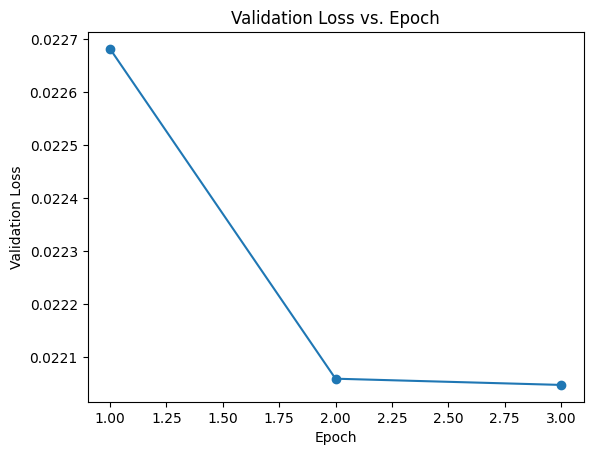

In [22]:
#validation loss vs epoch graph 
plt.plot(range(1, len(validation_loss) + 1),validation_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')
plt.show()


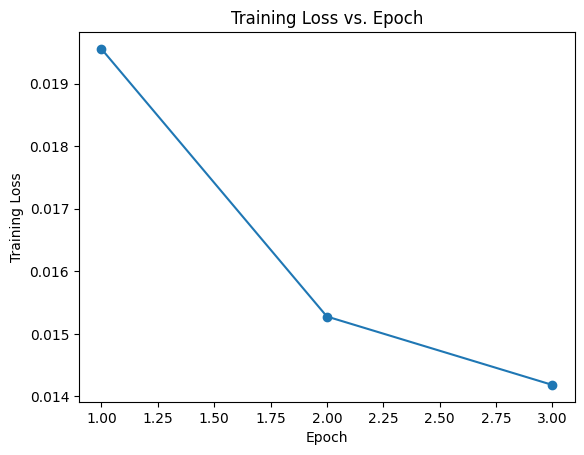

In [23]:
#training loss per epoch graph
loss_values_per_epoch = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in training_loss]
# Plot the graph
plt.plot(range(1, len(loss_values_per_epoch) + 1), loss_values_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
# plt.grid(True)
plt.show()


Pipeline for testing the model and getting the score

In [9]:
#Evaluation the model on dev dataset
model = SentenceTransformer("nli-distilroberta-base-v2-2024-03-30_10-18-28")

In [10]:
cosine_sim = []
for batch in dev_loader:
    sentences1, sentences2, _ = batch
    embed1 = model.encode(sentences1)
    embed2 = model.encode(sentences2)
    temp = cosine_similarity(embed1.reshape(1,-1),embed2.reshape(1,-1))
    #scaling up the similarity score
    #has a range from -1 to 1 and there are some negative values which have been set to 0
    scaled_cosine = temp[0][0]*5
    if(scaled_cosine<0):
        scaled_cosine=0
    cosine_sim.append(scaled_cosine)

pearson = np.corrcoef(cosine_sim,dev['score'])

In [12]:
print("Evaluation Metric for task 1C: ",pearson[0][1])

Evaluation Metric for task 1C:  0.8881361881690769


In [24]:
def pipeline(path,model_path):
    test_data = pd.read_csv(path,sep="\t")
    test_data = test_data.dropna().reset_index(drop = True)
    model = SentenceTransformer(model_path)
    dataset = TextDataset(test_data)
    test_dataloader = DataLoader(dataset,batch_size=1,shuffle=False)   
    
    scores_predicted = []
    for batch in test_dataloader:
        s1,s2 = batch
        embed1 = model.encode(s1)
        embed2 = model.encode(s2)
        temp = cosine_similarity(embed1.reshape(1,-1),embed2.reshape(1,-1))
        #scaling up the similarity score
        #has a range from -1 to 1 and there are some negative values which have been set to 0
        scaled_cosine = temp[0][0]*5
        if(scaled_cosine<0):
            scaled_cosine=0
        scores_predicted.append(scaled_cosine)
    
    test_data["score"] = scores_predicted
    test_data.to_csv("output_test.csv")    

In [25]:
#testing pipeline on sample demo given
pipeline("Data\sample_test.csv","nli-distilroberta-base-v2-2024-03-30_10-18-28")